## This Note Loads the dataset and does the augmentations on RAM (on memory) unlike the other ones.

---

# PART 1: IMPORT LIBRARIES AND MOUNT GOOGLE DRIVE

In [1]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

`tqdm` is used to show **progress bars** during loops.

It's used when:
* Finding minimum frames (PART 4) - Shows progress while scanning all videos
* Loading videos (PART 5) - Shows progress while loading non-shoplifter and shoplifter videos
* Applying augmentation (PART 9) - Shows progress while augmenting the training data

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

2025-10-15 19:01:23.070822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760554883.325888      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760554883.396325      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
print("Libraries imported and Drive mounted successfully!")

Libraries imported and Drive mounted successfully!


___

# PART 2: EXTRACT ZIP FILE AND SET PATHS

In [7]:
# ZIP_PATH = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 6: Shop Lifting Detection models from scratch/Shop DataSet.zip'
# EXTRACT_PATH = '/content/shop_data'

### Extract zip file from Google Drive

In [8]:
# def extract_zip_file(zip_path, extract_path):
#     if not os.path.exists(extract_path):
#         os.makedirs(extract_path)
#         print(f"Extracting {zip_path}...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         print("Extraction complete!")
#     else:
#         print("Data already extracted!")

#     # List contents (top level only, break will stop after top level search)
#     for root, dirs, files in os.walk(extract_path):
#         print(f"\nDirectory: {root}")
#         print(f"Subdirectories: {dirs}")
#         print(f"Files count: {len(files)}")
#         break

In [9]:
# extract_zip_file(ZIP_PATH, EXTRACT_PATH)

### DEBUG: Find actual folder structure

In [10]:
# print("Exploring extracted contents...")
# for root, dirs, files in os.walk(EXTRACT_PATH):
#     level = root.replace(EXTRACT_PATH, '').count(os.sep)
#     indent = ' ' * 2 * level
#     print(f'{indent}{os.path.basename(root)}/')
#     subindent = ' ' * 2 * (level + 1)
#     for file in files[:5]:  # Show first 5 files
#         print(f'{subindent}{file}')
#     if len(files) > 5:
#         print(f'{subindent}... and {len(files)-5} more files')

### Set dataset paths

In [11]:
## Kaggle

DATASET_PATH = '/kaggle/input/shop-lifting-dataset/Shop DataSet'
NON_SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, 'non shop lifters')
SHOPLIFTERS_PATH = os.path.join(DATASET_PATH, 'shop lifters')

---

# PART 3: CONFIGURATION AND HYPERPARAMETERS

In [12]:
## Video processing parameters
# IMG_HEIGHT = 128
# IMG_WIDTH = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64

NUM_FRAMES = 50
# NUM_FRAMES = 75  # Number of frames to extract from each video (from the min frames function)

CHANNELS = 3

In [13]:
## Training parameters
BATCH_SIZE = 4

# EPOCHS = 100
EPOCHS = 50

LEARNING_RATE = 0.001

In [14]:
## Class labels, Multi-classification
CLASS_NAMES = ['non_shoplifter', 'shoplifter']
NUM_CLASSES = len(CLASS_NAMES)

In [15]:
# NUM_CLASSES = 1  # Binary classification (non-shoplifter or shoplifter)

In [16]:
print("Configuration set: \n")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Frames per video: {NUM_FRAMES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {CLASS_NAMES}")

Configuration set: 

Image size: 64x64
Frames per video: 50
Batch size: 4
Classes: ['non_shoplifter', 'shoplifter']


___

# PART 4: FIND MINIMUM FRAMES IN DATASET

**Find the video with the fewest number of frames in the entire dataset**

In [17]:
def find_minimum_frames(non_shoplifters_path, shoplifters_path):
    min_frames = float('inf')
    min_video_path = None

    print("Scanning non-shoplifter videos...")
    non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
                            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(non_shoplifter_files):
        video_path = os.path.join(non_shoplifters_path, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        if total_frames > 0 and total_frames < min_frames:
            min_frames = total_frames
            min_video_path = video_path

    print("Scanning shoplifter videos...")
    shoplifter_files = [f for f in os.listdir(shoplifters_path)
                        if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(shoplifter_files):
        video_path = os.path.join(shoplifters_path, video_file)
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        if total_frames > 0 and total_frames < min_frames:
            min_frames = total_frames
            min_video_path = video_path

    print(f"\n{'='*60}")
    print(f"Minimum frames in dataset: {min_frames}")
    print(f"Video path: {min_video_path}")
    print('='*60)

    return min_frames, min_video_path

In [18]:
## Find minimum frames
min_frames, min_video_path = find_minimum_frames(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)

Scanning non-shoplifter videos...


100%|██████████| 531/531 [00:08<00:00, 66.16it/s]


Scanning shoplifter videos...


100%|██████████| 324/324 [00:06<00:00, 48.88it/s]


Minimum frames in dataset: 75
Video path: /kaggle/input/shop-lifting-dataset/Shop DataSet/non shop lifters/shop_lifter_n_215_1.mp4




---

# PART 5: Video Preprocessing Functions

### Extract fixed number of frames from video with temporal sampling

In [19]:
# def extract_frames_from_video(video_path, num_frames=NUM_FRAMES):
#     cap = cv2.VideoCapture(video_path)
#     total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     if total_frames == 0:
#         cap.release()
#         return None

#     # Calculate frame indices to extract (evenly spaced)
#     frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

#     frames = []
#     for idx in frame_indices:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#         ret, frame = cap.read()
#         if ret:
#             # Resize and normalize
#             frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
#             frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             frames.append(frame)
#         else:
#             # If frame reading fails, use black frame
#             # frames.append(np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))
#             print(f"Failed to read frame at index {idx} from video {video_path}")
#             break

#     cap.release()

#     # Ensure we have exactly num_frames
#     while len(frames) < num_frames:
#         frames.append(frames[-1] if frames else np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))

#     return np.array(frames[:num_frames])

In [20]:
def extract_frames_from_video(video_path, num_frames=NUM_FRAMES, jitter=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        cap.release()
        return None

    # Add random start index for temporal jitter
    if jitter and total_frames > num_frames:
        max_start = total_frames - num_frames
        start_idx = np.random.randint(0, max_start + 1)
    else:
        start_idx = 0

    # Evenly spaced indices with optional jitter start
    frame_indices = np.linspace(start_idx, start_idx + num_frames - 1, num_frames, dtype=int)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)

    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            print(f"Failed to read frame {idx} from {video_path}!!!")
            break

    cap.release()

    # Ensure correct length
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8))

    return np.array(frames[:num_frames])


**Improved** `extract_frames_from_video()`

Adds random temporal offset so your model doesn’t see identical frame sequences every time.

**What’s new**:

* Randomized start point (start_idx) adds temporal variety.

* Still guarantees num_frames output (pads/truncates safely).

* Keeps motion information consistent and prevents identical sequences.

### Normalize Frames

In [21]:
def normalize_frames(frames):
    return frames.astype(np.float32) / 255.0

### Complete preprocessing pipeline for a single video

In [22]:
def preprocess_video(video_path):
    frames = extract_frames_from_video(video_path)
    if frames is None:
        return None
    frames = normalize_frames(frames)
    return frames



---

# PART 5: LOAD DATASET

### Load all videos and their labels from both directories

In [23]:
def load_video_dataset(non_shoplifters_path, shoplifters_path):
    videos = []
    labels = []

    print("Loading non-shoplifter videos...")
    non_shoplifter_files = [f for f in os.listdir(non_shoplifters_path)
                            if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(non_shoplifter_files):
        video_path = os.path.join(non_shoplifters_path, video_file)
        frames = preprocess_video(video_path)
        if frames is not None:
            videos.append(frames)
            labels.append(0)  # 0 for non-shoplifter

    print(f"\nLoading shoplifter videos...")
    shoplifter_files = [f for f in os.listdir(shoplifters_path)
                        if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for video_file in tqdm(shoplifter_files):
        video_path = os.path.join(shoplifters_path, video_file)
        frames = preprocess_video(video_path)
        if frames is not None:
            videos.append(frames)
            labels.append(1)  # 1 for shoplifter

    videos = np.array(videos)
    labels = np.array(labels)

    print("\nDataset loaded successfully!\n")
    print(f"Total videos: {len(videos)}")
    print(f"Non-shoplifters: {np.sum(labels == 0)}")
    print(f"Shoplifters: {np.sum(labels == 1)}")
    print(f"Video shape: {videos.shape}")

    return videos, labels

In [24]:
# Load the dataset
# X, y = load_video_dataset(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)
videos, labels = load_video_dataset(NON_SHOPLIFTERS_PATH, SHOPLIFTERS_PATH)

Loading non-shoplifter videos...


100%|██████████| 531/531 [10:17<00:00,  1.16s/it]



Loading shoplifter videos...


100%|██████████| 324/324 [13:58<00:00,  2.59s/it]



Dataset loaded successfully!

Total videos: 855
Non-shoplifters: 531
Shoplifters: 324
Video shape: (855, 50, 64, 64, 3)


---

# PART 6: TRAIN-TEST SPLIT

In [25]:
# Split data into train and test sets (80-20 split)
videos_train, videos_test, labels_train, labels_test = train_test_split(
    videos, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {videos_train.shape[0]} videos")
print(f"Test set: {videos_test.shape[0]} videos")
print(f"Training non-shoplifters: {np.sum(labels_train == 0)}")
print(f"Training shoplifters: {np.sum(labels_train == 1)}")
print(f"Test non-shoplifters: {np.sum(labels_test == 0)}")
print(f"Test shoplifters: {np.sum(labels_test == 1)}")

Training set: 684 videos
Test set: 171 videos
Training non-shoplifters: 425
Training shoplifters: 259
Test non-shoplifters: 106
Test shoplifters: 65


The `stratify=labels` parameter in the `train_test_split` function ensures that the split is performed in a way that maintains the same proportion of classes in both the training and testing sets as in the original dataset.

This is particularly important when dealing with imbalanced datasets, where one class is significantly more represented than others.

It helps to prevent the model from being biased towards the majority class.

---

# PART 7: AUGMENTATION FUNCTIONS - INDIVIDUAL PREVIEW

In [26]:
import albumentations as A

### Create Albumentations Pipeline

In [27]:
def get_augmentation_pipeline():
    """Create Albumentations pipeline for spatial augmentations"""
    return A.ReplayCompose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.4),
        # A.Rotate(limit=15, p=0.3),
        
        # Removed A.RandomScale - it changes image dimensions
        # Using ShiftScaleRotate instead which maintains size
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=0,  # Rotation already handled above
            border_mode=cv2.BORDER_CONSTANT,
            p=0.3
        ),
    ])

#### E:

`p=1.0` for individual Augmentation Technique Visualization

Uses `ReplayCompose` to apply same transformation to **all frames** in the video.

`ReplayCompose` in general is used when dealing with **videos**.

### Temporal crop - not in albumentations, manual implementation

In [28]:
# def augment_temporal_crop(frames, crop_ratio=0.95):
#     """
#     Temporal augmentation - crop and resample video
#     **GUARANTEES output has same length as input
#     """
#     num_frames = len(frames)
#     crop_length = max(1, int(num_frames * crop_ratio))  # Ensure at least 1 frame

#     if crop_length >= num_frames:
#         return frames  # No cropping needed

#     start_idx = np.random.randint(0, num_frames - crop_length + 1)
#     cropped = frames[start_idx:start_idx + crop_length]

#     # Resample back to original length
#     indices = np.linspace(0, len(cropped) - 1, num_frames, dtype=int)
#     return cropped[indices]

#### E:

**Why Use Temporal Crop?**

It helps your model learn that **the exact timing of actions isn't fixed**, only **their visual pattern** matters.

For example:

* A shoplifter might reach for an item at frame 10 in one video and frame 20 in another.

* Temporal cropping ensures your model doesn’t overfit to “where” in time the event occurs.

So it introduces **temporal invariance** — the model becomes robust to when something happens in the sequence.

Step-by-step:

1. Takes, say, 30 frames (num_frames = 30).

2. Randomly selects 80% of them (crop_length = 24).

3. Chooses a random starting point (e.g., frame 5).

4. Extracts frames [F5 … F28].

5. Then stretches or samples back to 30 frames for model consistency.

### Apply single Augmentation for Visualization

In [29]:
def apply_single_augmentation(frames, aug_name):
    """Apply single augmentation with p=1.0"""
    frames_uint8 = (frames * 255).astype(np.uint8)

    if aug_name == 'Horizontal Flip':
        transform = A.HorizontalFlip(p=1.0)
    elif aug_name == 'Brightness':
        transform = A.RandomBrightnessContrast(brightness_limit=0.3, p=1.0)
    # elif aug_name == 'Rotation':
        # transform = A.Rotate(limit=15, p=1.0)
    elif aug_name == 'Zoom':
        transform = A.RandomScale(scale_limit=0.2, p=1.0)
    # elif aug_name == 'Temporal Crop':
        # return augment_temporal_crop(frames, crop_ratio=0.95)

    # Apply same transform to all frames using ReplayCompose
    replay_transform = A.ReplayCompose([transform])
    data = replay_transform(image=frames_uint8[0])

    augmented = []
    for frame in frames_uint8:
        aug_frame = A.ReplayCompose.replay(data['replay'], image=frame)
        augmented.append(aug_frame['image'].astype(np.float32) / 255.0)

    return np.array(augmented)

In [30]:
def preview_individual_augmentations(X_train, num_samples=3):
    """Preview each augmentation separately"""
    augmentations = ['Horizontal Flip', 'Brightness', 'Zoom']
    # augmentations = ['Horizontal Flip', 'Brightness', 'Rotation', 'Zoom', 'Temporal Crop']
    
    for aug_name in augmentations:
        print(f"\n{'='*60}")
        print(f"Augmentation: {aug_name}")
        print('='*60)

        fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))

        for i in range(num_samples):
            idx = np.random.randint(0, len(X_train))
            original = X_train[idx]
            augmented = apply_single_augmentation(original.copy(), aug_name)

            frame_idx1 = NUM_FRAMES // 3
            frame_idx2 = 2 * NUM_FRAMES // 3

            if num_samples == 1:
                axes = axes.reshape(1, -1)

            axes[i, 0].imshow(original[frame_idx1])
            axes[i, 0].set_title(f'Original - Frame {frame_idx1}')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(augmented[frame_idx1])
            axes[i, 1].set_title(f'Augmented - Frame {frame_idx1}')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(original[frame_idx2])
            axes[i, 2].set_title(f'Original - Frame {frame_idx2}')
            axes[i, 2].axis('off')

            axes[i, 3].imshow(augmented[frame_idx2])
            axes[i, 3].set_title(f'Augmented - Frame {frame_idx2}')
            axes[i, 3].axis('off')

        plt.tight_layout()
        plt.show()


Augmentation: Horizontal Flip


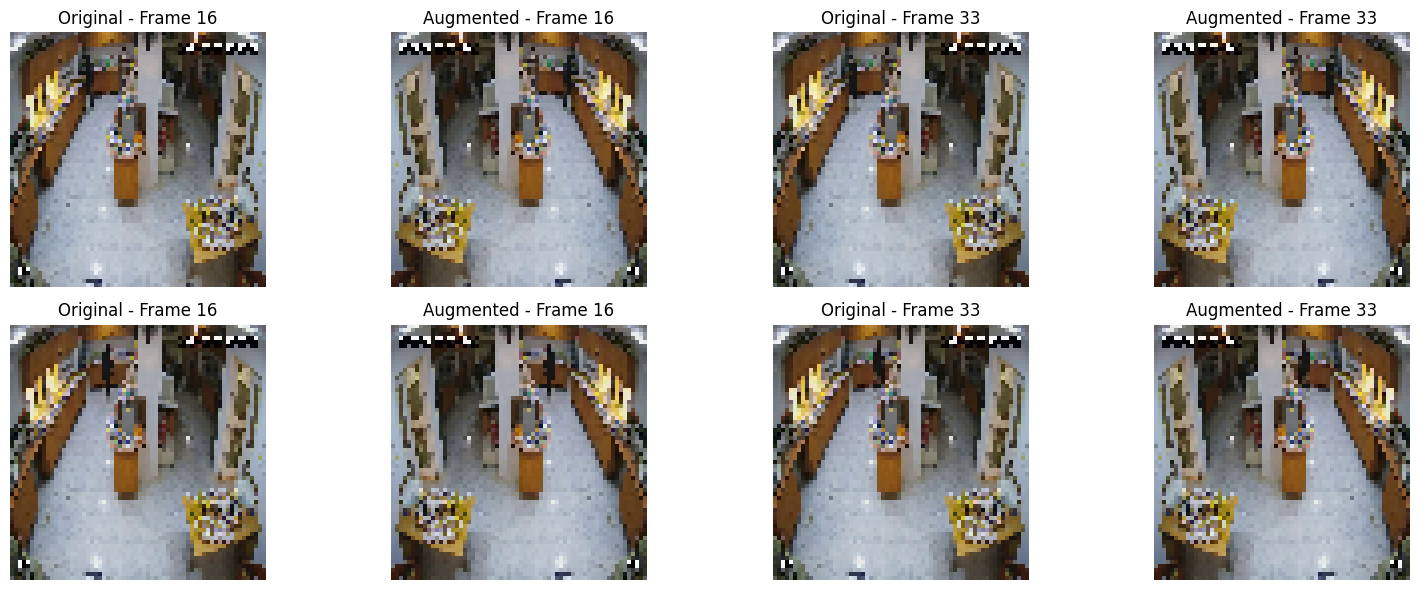


Augmentation: Brightness


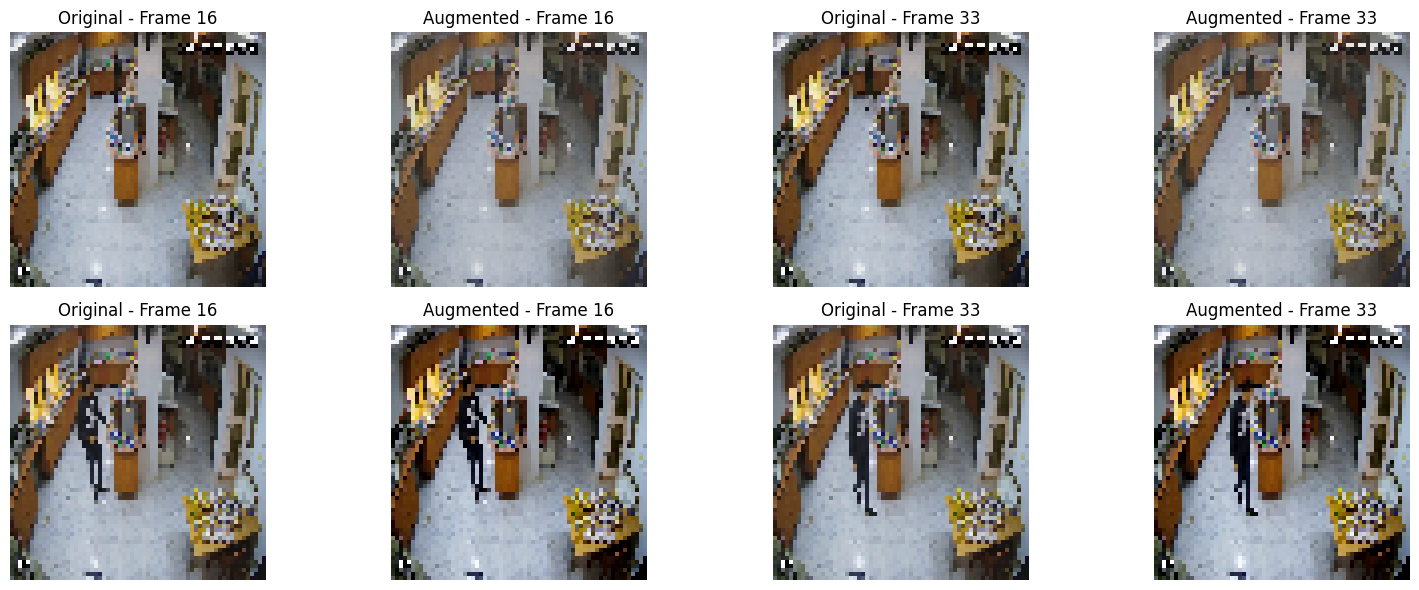


Augmentation: Zoom


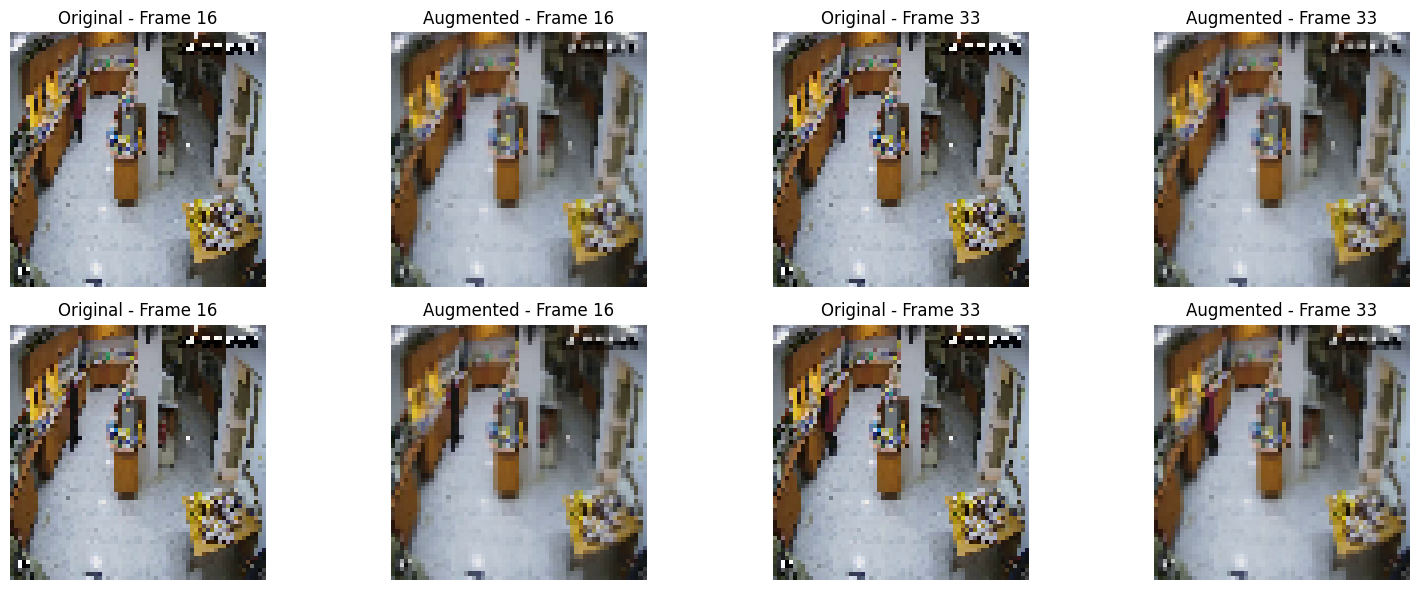

In [31]:
preview_individual_augmentations(videos_train, num_samples=2)

---

# PART 8: COMBINED AUGMENTATION WITH PROBABILITIES

### Apply Multiple Augmentations with Probabilities

In [32]:
# def apply_combined_augmentation(frames):
#     frames_uint8 = (frames * 255).astype(np.uint8)

#     # Spatial augmentations with probabilities
#     transform = A.ReplayCompose([
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, p=0.4),
#         # A.Rotate(limit=15, p=0.3)
#         # A.RandomScale(scale_limit=0.2, p=0.3),
#     ])

#     # Apply to all frames consistently
#     data = transform(image=frames_uint8[0])
#     augmented = []
#     for frame in frames_uint8:
#         aug_frame = A.ReplayCompose.replay(data['replay'], image=frame)
#         augmented.append(aug_frame['image'].astype(np.float32) / 255.0)

#     augmented = np.array(augmented)

#     # Temporal crop (manual, not in albumentations)
#     if np.random.random() < 0.3:
#         augmented = augment_temporal_crop(augmented)

#     return augmented

In [33]:
# def apply_combined_augmentation(frames, augment=True): # from other file (no Aug)
#     """
#     Apply augmentation to video frames
#     frames: normalized float32 array (0-1)
#     GUARANTEES output has same shape as input
#     """
#     if not augment:
#         return frames

#     input_shape = frames.shape

#     # Convert to uint8 for Albumentations
#     frames_uint8 = (frames * 255).astype(np.uint8)

#     # Apply spatial augmentations consistently across all frames
#     transform = get_augmentation_pipeline()
#     data = transform(image=frames_uint8[0])

#     augmented = []
#     for frame in frames_uint8:
#         aug_frame = A.ReplayCompose.replay(data['replay'], image=frame)
#         augmented.append(aug_frame['image'].astype(np.float32) / 255.0)

#     augmented = np.array(augmented)

#     ## Apply temporal crop with probability
#     # if np.random.random() < 0.3:
#         # augmented = augment_temporal_crop(augmented)

#     # CRITICAL: Ensure output shape matches input
#     if augmented.shape != input_shape:
#         print(f"ERROR: Shape mismatch in augmentation! Input: {input_shape}, Output: {augmented.shape}")
#         # Force correct shape by padding/truncating
#         if len(augmented) < input_shape[0]:
#             # Pad
#             padding = input_shape[0] - len(augmented)
#             augmented = np.concatenate([augmented, np.repeat(augmented[-1:], padding, axis=0)], axis=0)
#         elif len(augmented) > input_shape[0]:
#             # Truncate
#             augmented = augmented[:input_shape[0]]

#     return augmented

**Corrected** `apply_combined_augmentation()`

The original version replays the same augmentation on every single frame, which often results in flat, identical sequences.

The new version applies **one consistent transform** across all frames with a single replay instance — as intended.

In [34]:
def apply_combined_augmentation(frames, augment=True):
    """
    Apply consistent spatial augmentation across all frames of a video.
    Keeps temporal integrity intact.
    """
    if not augment:
        return frames

    input_shape = frames.shape
    frames_uint8 = (frames * 255).astype(np.uint8)

    transform = get_augmentation_pipeline()
    
    # Apply once to the first frame to generate a replay record
    data = transform(image=frames_uint8[0])
    replay_params = data['replay']

    # Apply the same replay transform to all frames
    augmented = [
        A.ReplayCompose.replay(replay_params, image=frame)['image'].astype(np.float32) / 255.0
        for frame in frames_uint8
    ]

    augmented = np.array(augmented)

    # Guarantee consistent shape
    if augmented.shape != input_shape:
        print(f"⚠️ Shape mismatch in augmentation! Input: {input_shape}, Output: {augmented.shape}")
        augmented = np.resize(augmented, input_shape)

    return augmented

✅ **What’s fixed/improved**:

* Only one replay is generated per video → consistent transform.

* All frames share the same affine and brightness adjustments (preserves temporal consistency).

* Outputs always maintain `(num_frames, H, W, C)`.

### Visualizing the Multiple Augmentations

In [35]:
# def visualize_combined_augmentation(X_train, num_samples=5):
#     """Visualize combined augmentation"""
#     print("\n" + "="*60)
#     print("Combined Augmentation Visualization")
#     print("="*60 + "\n")

#     fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 3))

#     for i in range(num_samples):
#         idx = np.random.randint(0, len(X_train))
#         original = X_train[idx]
#         augmented = apply_combined_augmentation(original.copy())

#         frame_idx1 = NUM_FRAMES // 3
#         frame_idx2 = 2 * NUM_FRAMES // 3

#         if num_samples == 1:
#             axes = axes.reshape(1, -1)

#         axes[i, 0].imshow(original[frame_idx1])
#         axes[i, 0].set_title(f'Before - Frame {frame_idx1}')
#         axes[i, 0].axis('off')

#         axes[i, 1].imshow(augmented[frame_idx1])
#         axes[i, 1].set_title(f'After - Frame {frame_idx1}')
#         axes[i, 1].axis('off')

#         axes[i, 2].imshow(original[frame_idx2])
#         axes[i, 2].set_title(f'Before - Frame {frame_idx2}')
#         axes[i, 2].axis('off')

#         axes[i, 3].imshow(augmented[frame_idx2])
#         axes[i, 3].set_title(f'After - Frame {frame_idx2}')
#         axes[i, 3].axis('off')

#     plt.tight_layout()
#     plt.show()

In [36]:
# visualize_combined_augmentation(videos_train, num_samples=6)

---

# PART 9: APPLY AUGMENTATION TO TRAINING DATA

### Fixed Function for the dimensions problem

In [37]:
def pad_videos_to_same_length(videos, target_frames=NUM_FRAMES):
    """
    Pad or truncate all videos to the same number of frames
    """
    padded_videos = []
    for video in videos:
        num_frames = len(video)
        if num_frames < target_frames:
            # Pad by repeating last frame
            padding_needed = target_frames - num_frames
            padding = np.repeat(video[-1:], padding_needed, axis=0)
            padded_video = np.concatenate([video, padding], axis=0)
        elif num_frames > target_frames:
            # Truncate by sampling evenly
            indices = np.linspace(0, num_frames - 1, target_frames, dtype=int)
            padded_video = video[indices]
        else:
            padded_video = video
        
        padded_videos.append(padded_video)
    
    return np.array(padded_videos)

### Fixed augment function

In [38]:
def augment_dataset(X, y, augmentation_factor=1):
    """
    Apply augmentation to increase dataset size
    augmentation_factor: how many augmented versions to create per sample
    """
    X_augmented = []
    y_augmented = []
    
    print("Applying augmentation to training data...")
    
    # Keep original data
    for i in range(len(X)):
        X_augmented.append(X[i])
        y_augmented.append(y[i])
    
    # Add augmented versions
    for _ in range(augmentation_factor):
        for i in tqdm(range(len(X))):
            augmented_frames = apply_combined_augmentation(X[i].copy())
            X_augmented.append(augmented_frames)
            y_augmented.append(y[i])
    
    # DON'T convert to numpy array yet - keep as list
    return X_augmented, y_augmented  # Return lists, not np.array()

In [39]:
# Apply augmentation to training data (create 1 augmented version per sample)
videos_train_aug, labels_train_aug = augment_dataset(videos_train, labels_train, augmentation_factor=1)

print(f"\nOriginal training set size: {len(videos_train)}")
print(f"Augmented training set size: {len(videos_train_aug)}")

Applying augmentation to training data...


100%|██████████| 684/684 [00:44<00:00, 15.43it/s]


Original training set size: 684
Augmented training set size: 1368


---

# PART 10: BUILD CNN+RNN MODEL

### Building the Model

In [40]:
from tensorflow.keras import regularizers

def build_cnn_rnn_model(input_shape, num_classes):
    """
    Build CNN+RNN model for video classification
    Architecture: CNN (feature extraction) -> RNN (temporal modeling) -> Dense
    """
    inputs = layers.Input(shape=input_shape)

    # CNN Feature Extractor (applied to each frame via TimeDistributed)
    x = layers.TimeDistributed(
        layers.Conv2D(32, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(1e-4))
    )(inputs)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Dropout(0.25))(x)

    x = layers.TimeDistributed(
        layers.Conv2D(64, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(1e-4))
    )(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Dropout(0.25))(x)

    x = layers.TimeDistributed(
        layers.Conv2D(128, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(1e-4))
    )(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    x = layers.TimeDistributed(
        layers.Conv2D(256, (3, 3), padding='same', 
                      kernel_regularizer=regularizers.l2(1e-4))
    )(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    # x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x) ## to preserve more spatial detail for the LSTM.
    x = layers.TimeDistributed(layers.Dropout(0.3))(x)

    # Flatten CNN output for each timestep
    x = layers.TimeDistributed(layers.Flatten())(x)

    # Dense layer after CNN features
    x = layers.TimeDistributed(layers.Dense(512))(x)
    x = layers.TimeDistributed(layers.BatchNormalization())(x)
    x = layers.TimeDistributed(layers.Activation('relu'))(x)
    x = layers.TimeDistributed(layers.Dropout(0.4))(x)

    # RNN layers (LSTM for temporal modeling)
    x = layers.LSTM(256, return_sequences=True, 
                    kernel_regularizer=regularizers.l2(1e-4),
                    recurrent_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.LSTM(128, return_sequences=False,
                   kernel_regularizer=regularizers.l2(1e-4),
                   recurrent_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers for classification
    x = layers.Dense(128, 
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    ## Output layer (softmax, multi classification)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    ## Output Layer (sigmoid, binary classification)
    # outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

**Added Regularization** for some layers except for CNN, since it has `Batch Normalization` and `dropout`

For `LSTM RNN`, the reason is **Temporal modeling can easily memorize frame order.**

For `Fully connected`, the reason is **Fully connected — tends to overfit most**

Dense(64) is a small layer so regularization is optional

In [41]:
input_shape = (NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

nn_model = build_cnn_rnn_model(input_shape, NUM_CLASSES)

I0000 00:00:1760556422.481441      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760556422.482255      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [42]:
print("Model built successfully!")
nn_model.summary()

Model built successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 50, 64, 64, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 50, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 50, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 50, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 50, 32, 32, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 50, 32, 32, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 50, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 50, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 50, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 50, 16, 16,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 50, 16, 16,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 50, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 50, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 50, 8, 8, 256)  │       295,168 │
│ (TimeDistributed)               │                        │             

 Total params: 9,793,282 (37.36 MB)

 Trainable params: 9,790,146 (37.35 MB)

 Non-trainable params: 3,136 (12.25 KB)

### Compile the Model

In [43]:
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**for sigmoid (binary classification)**

In [44]:
# @title
# nn_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

---

# PART 11: SETUP CALLBACKS AND TRAIN MODEL

In [45]:
# Create directory for saving models
os.makedirs('/kaggle/working/models', exist_ok=True)

In [46]:
# Define callbacks
checkpoint = ModelCheckpoint(
    '/kaggle/working/models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [47]:
callbacks = [checkpoint, reduce_lr, early_stopping]

For **softmax only**

Comment for **sigmoid**

In [48]:
## Convert labels to categorical for training (softmax, not needed for sigmoid, I used sparse categorical crossentropy, so I don't need to OHE the label)
# y_train_cat = to_categorical(labels_train_aug, num_classes=NUM_CLASSES)

In [49]:
# Train the model
# print("\nStarting training...")
# nn_model_fit = nn_model.fit(
#     videos_train_aug, labels_train_aug,
#     batch_size=BATCH_SIZE,
#     epochs=EPOCHS,
#     validation_split=0.2,
#     callbacks=callbacks,
#     shuffle=True,
#     verbose=1
# )

# print("\nTraining completed!")

### Conversion to numpy before training

In [50]:
# Train the model
print("\nStarting training...")

# Pad videos to same length before training
print("Padding videos to uniform length...")
videos_train_aug_padded = pad_videos_to_same_length(videos_train_aug, target_frames=NUM_FRAMES)
labels_train_aug_array = np.array(labels_train_aug)

print(f"Padded training shape: {videos_train_aug_padded.shape}")

nn_model_fit = nn_model.fit(
    np.array(videos_train_aug), np.array(labels_train_aug),  # Convert to numpy here during fit
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Starting training...
Padding videos to uniform length...
Padded training shape: (1368, 50, 64, 64, 3)
Epoch 1/50


I0000 00:00:1760556591.797420    6971 cuda_dnn.cc:529] Loaded cuDNN version 90300


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.5451 - loss: 1.0627
Epoch 1: val_accuracy improved from -inf to 0.56934, saving model to /kaggle/working/models/best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 349s 691ms/step - accuracy: 0.5451 - loss: 1.0626 - val_accuracy: 0.5693 - val_loss: 0.9202 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.5999 - loss: 0.9425
Epoch 2: val_accuracy improved from 0.56934 to 0.60949, saving model to /kaggle/working/models/best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 167s 610ms/step - accuracy: 0.6000 - loss: 0.9424 - val_accuracy: 0.6095 - val_loss: 0.8809 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.6009 - loss: 0.9392
Epoch 3: val_accuracy did not improve from 0.60949
274/274 ━━━━━━━━━━━━━━━━━━━━ 166s 606ms/step - accuracy: 0.6010 - loss: 0.9391 - val_accuracy: 0.5839 - val_loss: 0.9417 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 

---

# PART 12: PLOT TRAINING HISTORY

In [51]:
def plot_training_history(model):
    """
    Plot accuracy and loss curves
    """
    # Plot Accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'], label='Training Accuracy', linewidth=2, color="blue")
    plt.plot(model.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color="green")
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'], label='Training Loss', linewidth=2, color="red")
    plt.plot(model.history['val_loss'], label='Validation Loss', linewidth=2, color="orange")
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

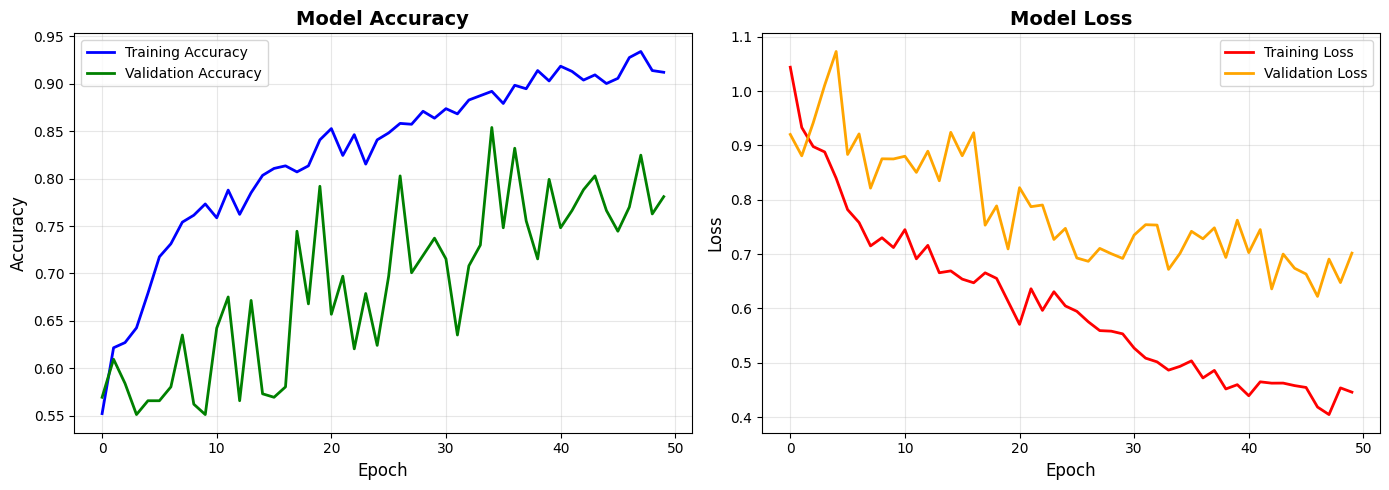

In [52]:
## Plot training history
plot_training_history(nn_model_fit)

---

# PART 13: EVALUATE MODEL ON TEST SET

In [53]:
# Load best model
nn_model.load_weights('/kaggle/working/models/best_model.keras')

In [54]:
# Make predictions on test set
print("Making predictions on test set...")
labels_pred_probs = nn_model.predict(videos_test, batch_size=BATCH_SIZE)

## Softmax
labels_pred = np.argmax(labels_pred_probs, axis=1)

## Sigmoid
# labels_pred = (labels_pred_probs > 0.5).astype(int).flatten()  # Change from argmax

print("Predictions completed!")

Making predictions on test set...
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step
Predictions completed!


---

# PART 14: CLASSIFICATION REPORT AND METRICS

In [55]:
# Calculate metrics
accuracy = accuracy_score(labels_test, labels_pred)
precision = precision_score(labels_test, labels_pred, average='weighted')
recall = recall_score(labels_test, labels_pred, average='weighted')
f1 = f1_score(labels_test, labels_pred, average='weighted')

In [56]:
print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


MODEL EVALUATION METRICS

Accuracy:  0.9415
Precision: 0.9493
Recall:    0.9415
F1-Score:  0.9422


In [57]:
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(labels_test, labels_pred, target_names=CLASS_NAMES))


CLASSIFICATION REPORT
                precision    recall  f1-score   support

non_shoplifter       1.00      0.91      0.95       106
    shoplifter       0.87      1.00      0.93        65

      accuracy                           0.94       171
     macro avg       0.93      0.95      0.94       171
  weighted avg       0.95      0.94      0.94       171



---

# PART 15: CONFUSION MATRIX VISUALIZATION

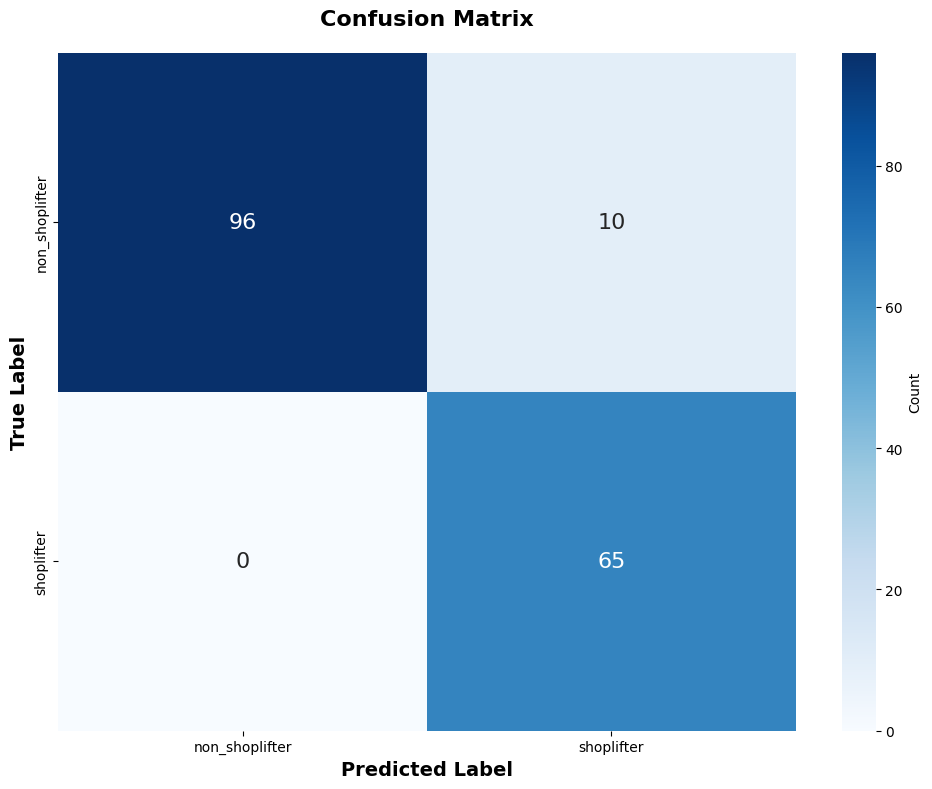

In [58]:
## Compute confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

## Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [59]:
# Print confusion matrix values
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")


Confusion Matrix:
[[96 10]
 [ 0 65]]

True Negatives:  96
False Positives: 10
False Negatives: 0
True Positives:  65


---

# Part 16: ROC Curve Evaluation

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(nn_model, videos_test, labels_test, BATCH_SIZE):
    """
    Plot ROC curve and compute AUC for binary classification.
    Assumes model outputs softmax probabilities with shape (N, 2).
    """
    print("\nComputing ROC curve and AUC score...")

    # Predict probabilities on test set
    labels_pred_probs = nn_model.predict(videos_test, batch_size=BATCH_SIZE)

    # Extract probability of the positive class (index 1)
    y_pred_proba = labels_pred_probs[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels_test, y_pred_proba)
    auc_score = roc_auc_score(labels_test, y_pred_proba)

    # Print AUC
    print(f"AUC Score: {auc_score:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Computing ROC curve and AUC score...
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
AUC Score: 1.0000


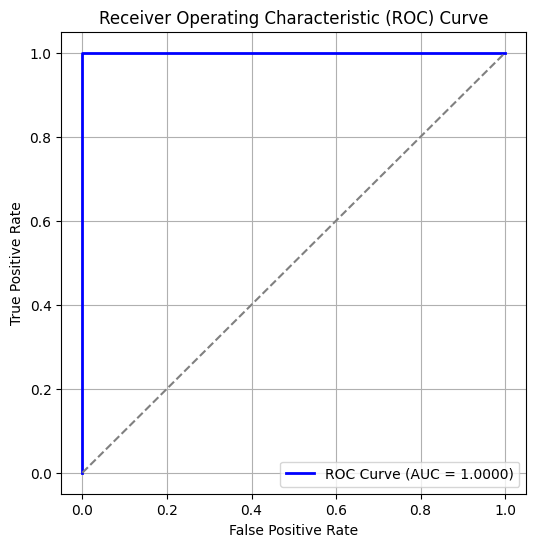

In [66]:
# Plot ROC curve + AUC
plot_roc_auc(nn_model, videos_test, labels_test, BATCH_SIZE)


`ROC — Receiver Operating Characteristic`

* It’s a curve that shows how well your model can distinguish between classes.

* The ROC curve plots:

    * `True Positive Rate (TPR)` on the **y-axis** (also called Recall or Sensitivity)

    * `False Positive Rate (FPR)` on the **x-axis**


* Each point on the ROC curve corresponds to a different classification threshold (from 0 → 1).

In simpler terms:

ROC shows how your model’s performance changes as you vary the threshold for deciding what counts as “positive”.

`AUC — Area Under the Curve` (of the ROC curve)

* It’s a single number that summarizes the ROC curve.

* Ranges from 0 to 1:

    * `1.0` → `Perfect classifier`

    * `0.5` → `Random guessing`

    * `<0.5` → `Worse than random` (model is confused or flipped)

👉 In short:

AUC tells you how well the model ranks positive examples higher than negative ones.

* **ROC curve** = visual performance at all thresholds

* **AUC** = numeric summary of how good that curve is

---

# PART 17: SAMPLE PREDICTIONS VISUALIZATION

In [60]:
def visualize_predictions(X_test, y_test, y_pred, num_samples=6):
    """
    Visualize sample predictions with ground truth and predicted labels
    """
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        # Get middle frame from video
        frame = X_test[idx][NUM_FRAMES // 2]
        true_label = CLASS_NAMES[y_test[idx]]
        pred_label = CLASS_NAMES[y_pred[idx]]

        # Determine if prediction is correct
        color = 'green' if y_test[idx] == y_pred[idx] else 'red'

        axes[i].imshow(frame)
        axes[i].set_title(f'True: {true_label}\nPredicted: {pred_label}',
                         color=color, fontweight='bold', fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


SAMPLE PREDICTIONS


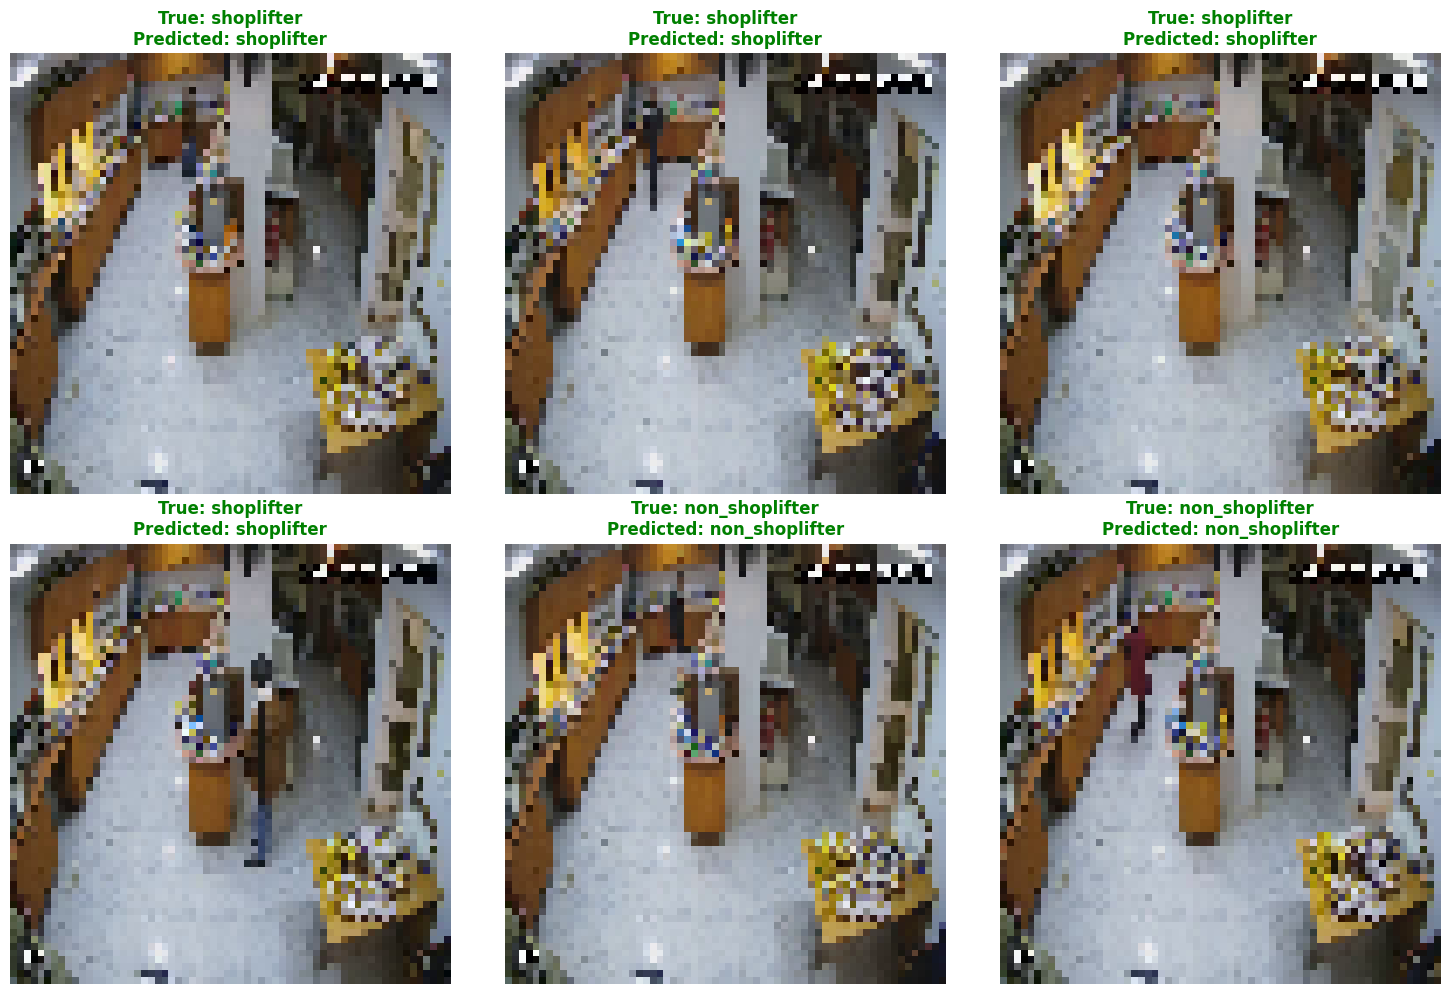

In [61]:
# Visualize sample predictions
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
visualize_predictions(videos_test, labels_test, labels_pred, num_samples=6)

---

---

### Improvements from Version 3

Improved `apply_combined_augmentation()`

Improved `extract_frames_from_video()`

Added Regularization and modified the `build_cnn_rnn_model` to reduce **overfitting**.